# 5. Timing analysis

We will produce a light curve of Mrk 421 in two energy bands, compute the ratio of the fluxes and see if there is any hint of spectral variability.

For this tutorial, we will need a few extra python packages (such as `astroquery` to query Virtual Observatory services).

In [1]:
# !mamba install -c conda-forge astroquery
#
# or:
#
# !mamba create -n cads-2024 -c conda-forge gammapy=1.2 ipykernel astroquery tqdm

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('tableau-colorblind10')

import numpy as np

from astropy import units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.time import Time
from astroquery.simbad import Simbad

import scipy


from gammapy.data import DataStore
from gammapy.datasets import Datasets, SpectrumDataset, SpectrumDatasetOnOff
from gammapy.estimators import FluxPointsEstimator, LightCurveEstimator
from gammapy.estimators.utils import (
    resample_energy_edges,
    compute_lightcurve_fvar,
    compute_lightcurve_fpp,
    compute_lightcurve_doublingtime
)
from gammapy.makers import (
    DatasetsMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
)
from gammapy.makers.utils import make_theta_squared_table
from gammapy.maps import MapAxis, RegionGeom, WcsGeom
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    PointSpatialModel,
    SkyModel,
)
from gammapy.utils import pbar
pbar.SHOW_PROGRESS_BAR = True
from gammapy.visualization import plot_spectrum_datasets_off_regions, plot_theta_squared_table

from regions import CircleSkyRegion

from IPython.display import display

/home/jlenain/local/opt/mambaforge/envs/cads-2024/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We first load the relevant data set:

In [3]:
data_store = DataStore.from_dir(
    f"$GAMMAPY_DATA/hess-dl3-dr1"
)

We set the properties of the source of interest. Bonus: we can use Virtual Observatory services to query the source parameters.

In [4]:
src = dict()
# src['Name'] = 'Mrk 421'
src['Name'] = 'PKS 2155-304'
src['Position'] = SkyCoord.from_name(src['Name'])

try:
    simbad = Simbad()
    simbad.add_votable_fields("z_value")
    query = simbad.query_object(src['Name'])
    src['Redshift'] = query["Z_VALUE"].data[0]
except NameError:
    src['Redshift'] = 0.030

We select a sub-sample of data acquired on our source:

In [5]:
selection = dict(
    type="sky_circle",
    frame="icrs",
    lon=src['Position'].ra,
    lat=src['Position'].dec,
    radius="3 deg",
)
selected_obs_table = data_store.obs_table.select_observations(selection)

selection = dict(
    type="time_box",
    time_range=Time(["2006-07-29T12:00", "2006-07-30T12:00"]),
)
selected_obs_table = selected_obs_table.select_observations(selection)

obs_ids = selected_obs_table["OBS_ID"]
observations = data_store.get_observations(obs_ids)

Obs Id: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 1120.75it/s]


# Data reduction

Let's perform a 1D analysis of the data.

In [6]:
on_region_radius = Angle("0.1 deg")

on_region = CircleSkyRegion(center=src['Position'], radius=on_region_radius)
exclusion_region = CircleSkyRegion(center=src['Position'],radius=0.5 * u.deg)
geom = WcsGeom.create(
    npix=(120, 120), binsz=0.05, skydir=src['Position'], proj="TAN", frame="icrs"
)
exclusion_mask = ~geom.region_mask([exclusion_region])

In [7]:
energy_axis = MapAxis.from_energy_bounds(0.02, 200, nbin=5, per_decade=True, unit="TeV", name="energy")
energy_axis_true = MapAxis.from_energy_bounds(0.005, 300, nbin=10, per_decade=True, unit="TeV", name="energy_true")

geom = RegionGeom.create(region=on_region, axes=[energy_axis])

dataset_empty = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)
dataset_maker = SpectrumDatasetMaker(containment_correction=True, selection=["counts", "exposure", "edisp"])

bkg_maker = ReflectedRegionsBackgroundMaker(exclusion_mask=exclusion_mask)
safe_mask_maker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

In [8]:
%%time

# Parallel version
makers = [dataset_maker, bkg_maker, safe_mask_maker]  # the order matters
datasets_maker = DatasetsMaker(makers, stack_datasets=False, n_jobs=8)
datasets = datasets_maker.run(dataset_empty, observations)

Data reduction: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 75709.46it/s]


CPU times: user 360 ms, sys: 62.6 ms, total: 423 ms
Wall time: 1.66 s


In [9]:
dataset_stack = datasets.stack_reduce()

datasets_joint = Datasets()

for dataset in datasets:
    datasets_joint.append(dataset)

Let's find the median energy of the data on our source to build two well-balanced sets into two energy bands:

In [10]:
excess = datasets[0].excess.data.T[0][0]
mask = excess > 0
excess = excess[mask]
energy_bins = datasets[0].counts.geom.axes['energy'].center[mask]
med_value = np.sum(excess) / 2.
med_mask = np.cumsum(excess) > med_value
e_median = energy_bins[med_mask][0]
print(f'Median energy: {e_median:.3f}')

Median energy: 1.002 TeV


In [11]:
e_min = dataset_stack.energy_range_safe[0].data[0][0] * dataset_stack.energy_range_safe[0].unit
e_max = dataset_stack.energy_range_safe[-1].data[0][0] * dataset_stack.energy_range_safe[0].unit
print(f'Energy threshold: {e_min:.3f}')
print(f'Maximal energy: {e_max:.3f}')

Energy threshold: 0.200 TeV
Maximal energy: 200.000 TeV


# Fit overall spectrum

In [12]:
spectral_model = PowerLawSpectralModel(amplitude=1.0e-11 * u.Unit("cm-2 s-1 TeV-1"),
                                       reference=e_median,
                                       index=2.
                                      )
spectral_model.parameters["amplitude"].frozen = False
spectral_model.parameters["index"].frozen = False

In [13]:
source = SkyModel(spectral_model=spectral_model,
                 name=src["Name"])

for ds in datasets_joint:
    ds.models = source

In [14]:
%%time

fit_joint = Fit()
result_joint = fit_joint.run(datasets=datasets_joint)

# we make a copy here of the optimised model for later use
model_best_joint = source.copy(name=src["Name"])

CPU times: user 1.64 s, sys: 4.19 ms, total: 1.64 s
Wall time: 1.64 s


In [15]:
print(result_joint)
display(result_joint.models.to_parameters_table())

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 94
	total stat : 3249.22

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



model,type,name,value,unit,error,min,max,frozen,is_norm,link,prior
str12,str1,str9,float64,str14,float64,float64,float64,bool,bool,str1,str1
PKS 2155-304,,index,3.3922e+00,,1.726e-02,nan,nan,False,False,,
PKS 2155-304,,amplitude,7.7443e-11,TeV-1 s-1 cm-2,1.246e-12,nan,nan,False,True,,
PKS 2155-304,,reference,1.0024e+00,TeV,0.000e+00,nan,nan,True,False,,


In [16]:
%%time

# Compute flux points

energy_edges = resample_energy_edges(dataset_stack, conditions={'sqrt_ts_min': 2.})

fpe = FluxPointsEstimator(
    energy_edges=energy_edges,
    source=src["Name"],
    selection_optional=["errn-errp", "ul", "scan"],
    fit=fit_joint,
    n_jobs=6,
)
flux_points = fpe.run(datasets_joint)

Energy bins:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 6/7 [00:00<00:00, 12.30it/s]Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Scan values: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.79it/s]

Reoptimize = False ignored for iminuit backend
Scan values: 100%|███████████████████████████████████████████████████████████████████████████████████████████

CPU times: user 913 ms, sys: 67.8 ms, total: 981 ms
Wall time: 6.44 s


<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='e2dnde [$\\mathrm{erg\\,s^{-1}\\,cm^{-2}}$]'>

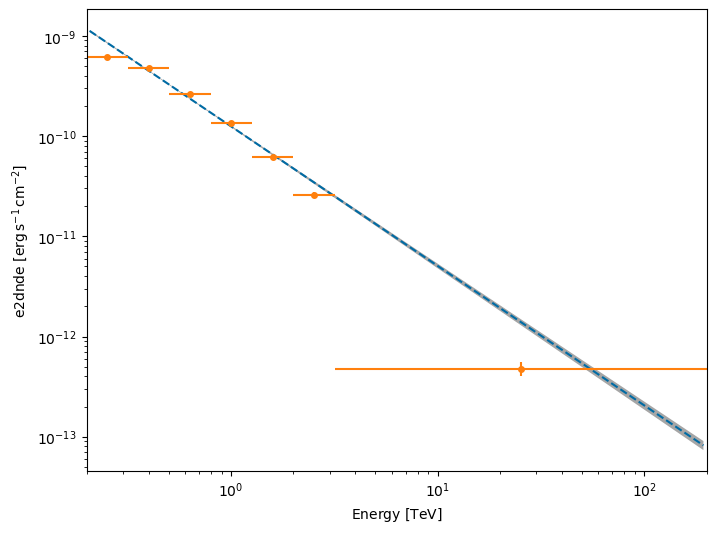

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_kwargs = {
    "energy_bounds": [e_min, e_max],
    "sed_type": "e2dnde",
    "yunits": u.Unit("erg cm-2 s-1"),
    "ax": ax,
}

# plot joint model
model_best_joint.spectral_model.plot(
    **plot_kwargs, ls="--"
)
model_best_joint.spectral_model.plot_error(facecolor="grey", alpha=0.7, **plot_kwargs)

flux_points.plot(ax=plot_kwargs["ax"],
                 sed_type=plot_kwargs["sed_type"],
                 )

# Light curve

Let's define a time axis and construct the light curve in two energy ranges

In [18]:
time_intervals = [Time([obs.tstart, obs.tstop]) for obs in observations]
time_intervals

[<Time object: scale='tt' format='mjd' value=[53945.85113639 53945.870685  ]>,
 <Time object: scale='tt' format='mjd' value=[53945.87218963 53945.89173824]>,
 <Time object: scale='tt' format='mjd' value=[53945.89321972 53945.91275676]>,
 <Time object: scale='tt' format='mjd' value=[53945.91428454 53945.93384472]>,
 <Time object: scale='tt' format='mjd' value=[53945.93536093 53945.95490954]>,
 <Time object: scale='tt' format='mjd' value=[53945.95648361 53945.97602065]>,
 <Time object: scale='tt' format='mjd' value=[53945.97769889 53945.9972475 ]>,
 <Time object: scale='tt' format='mjd' value=[53946.00427296 53946.02381   ]>,
 <Time object: scale='tt' format='mjd' value=[53946.02567343 53946.04522204]>,
 <Time object: scale='tt' format='mjd' value=[53946.04678454 53946.06633315]>,
 <Time object: scale='tt' format='mjd' value=[53946.06796509 53946.0875137 ]>,
 <Time object: scale='tt' format='mjd' value=[53946.08914565 53946.10869426]>,
 <Time object: scale='tt' format='mjd' value=[53946.

In [19]:
energy_lo = [e_min.value, e_median.value] * e_min.unit
energy_hi = [e_median.value, e_max.value] * e_max.unit
energy_all = [e_min.value, e_max.value] * e_min.unit

e_ranges = [energy_lo, energy_hi, energy_all]

In [30]:
lc_maker = LightCurveEstimator(energy_edges=[e_min, e_median, e_max],
                               source=model_best_joint.name,
                               time_intervals=time_intervals,
                               selection_optional=["errn-errp", "ul", "scan"],
                               n_jobs=6,
                              )
lc = lc_maker.run(datasets_joint)

Energy bins: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.91it/s]

Scan values: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 369.33it/s]

Scan values: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 211.33it/s]

Energy bins: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.25it/s]

Scan values: 100%|██████████████████████████████████████████

<Axes: xlabel='Time [mjd]', ylabel='flux [$\\mathrm{s^{-1}\\,cm^{-2}}$]'>

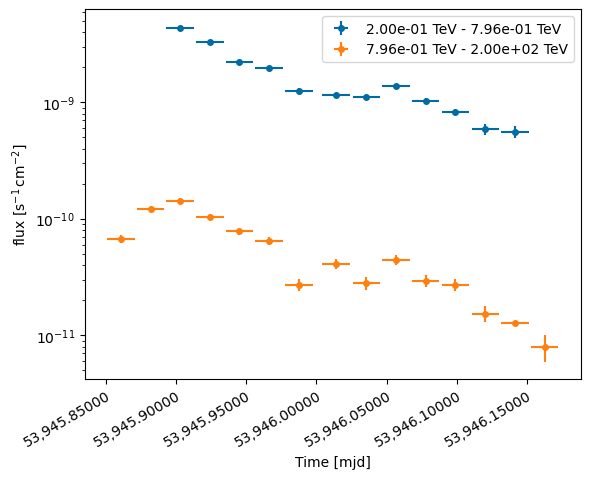

In [31]:
lc.plot(sed_type="flux", time_format="mjd", axis_name="time")

In [27]:
lcs = []

for e_range in e_ranges:
    print(f"Running light curve estimator on energy range: {e_range}")
    lc_maker = LightCurveEstimator(energy_edges=e_range,
                               source=model_best_joint.name,
                               time_intervals=time_intervals,
                               selection_optional=["errn-errp", "ul", "scan"],
                               n_jobs=6,
                              )
    # lc_maker.n_sigma = 1.
    # lc_maker.n_sigma_ul = 3.

    #try:
    lc = lc_maker.run(datasets_joint)
    #except ValueError:
    #    continue
    lcs.append(lc)

Running light curve estimator on energy range: [0.2        1.00237447] TeV


Energy bins: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]

Scan values: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 373.16it/s]

Scan values: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 396.28it/s]

Energy bins:   0%|                                                                                                                                                                                                 | 0/1 [00:00<?, ?it/s]

Energy bins: 100%|██████████████████████████████████████████

Running light curve estimator on energy range: [  1.00237447 200.        ] TeV


Energy bins: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]

Energy bins: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]

Energy bins: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.41it/s]

Energy bins:   0%|                                                                                                                                                                                                 | 0/1 [00:00<?, ?it/s]

Energy bins: 100%|██████████████████████████████████████████

Running light curve estimator on energy range: [  0.2 200. ] TeV


Energy bins: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]

Energy bins: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]

Scan values: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 365.16it/s]

Energy bins: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]

Energy bins: 100%|██████████████████████████████████████████

/home/jlenain/local/opt/mambaforge/envs/cads-2024/lib/python3.12/site-packages/gammapy/maps/region/ndmap.py:133: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


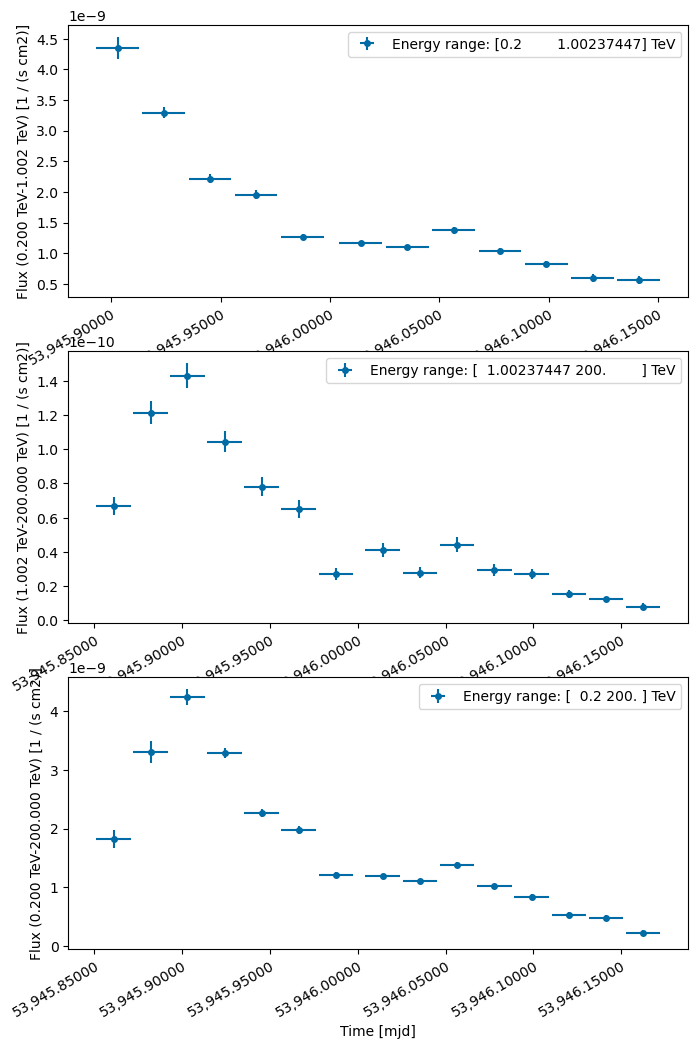

In [28]:
fig, ax = plt.subplots(len(lcs), figsize=(8,12))

for i, lc in enumerate(lcs):
    lc.plot(ax=ax[i],
            sed_type="flux",
            time_format="mjd",
            label=f'Energy range: {e_ranges[i]}',
           )
    ax[i].set_yscale('linear')
    ax[i].set_ylabel(f'Flux ({e_ranges[i][0]:.3f}-{e_ranges[i][1]:.3f}) [{lc.flux.unit}]')
    ax[i].legend()

# Fractional and point-to-point variability

In [32]:
compute_lightcurve_fvar(lc, flux_quantity='flux').pprint_all()

    min_energy         max_energy            fvar              fvar_err          significance   
       TeV                TeV                                                                   
------------------ ------------------ ------------------ -------------------- ------------------
               0.2 0.7962143411069947 0.6971518028677849 0.013655820952154918  51.05162152538129
0.7962143411069947 199.99999999999991  0.764110879216372 0.021720003862253846 35.180052640058854


In [33]:
compute_lightcurve_fpp(lc, flux_quantity='flux').pprint_all()

    min_energy         max_energy             fpp               fpp_err          significance   
       TeV                TeV                                                                   
------------------ ------------------ ------------------- ------------------- ------------------
               0.2 0.7962143411069947 0.32032616018152654 0.01371416293082083 23.357324963788667
0.7962143411069947 199.99999999999991  0.4412189258240722 0.02184961514072303  20.19344153123018


In [34]:
compute_lightcurve_doublingtime(lc, flux_quantity='flux').pprint_all()

    min_energy         max_energy        doublingtime       doubling_err      doubling_coord      halvingtime        halving_err       halving_coord  
       TeV                TeV                 s                  s                                     s                  s                           
------------------ ------------------ ------------------ ------------------ ------------------ ------------------ ------------------ -----------------
               0.2 0.7962143411069947  5830.358966618556 3.1075652473499353 53946.035447731476  2909.071408335514 13.561513040848645 53945.96625212963
0.7962143411069947 199.99999999999991 2111.6594738672998  43.99278272913416  53945.86091069444 1449.3582156039859  140.4124548887282 53945.96625212963


# Hardness ratio diagrams

Let's compute the flux ratio of our two light curves, plot them against time, and against the overall flux (i.e. hardness ratio diagram).

In [ ]:
# flux_ratio = lcs[0]/lcs[1]

In [43]:
lc.to_table()

time_min,time_max,e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,norm,norm_err,norm_errn,norm_errp,norm_ul,ts,sqrt_ts,npred,npred_excess,stat,stat_null,is_ul,counts,success,stat_scan,norm_scan
,,TeV,TeV,TeV,1 / (TeV s cm2),1 / (s cm2),TeV / (s cm2),,,,,,,,,,,,,,,,
float64,float64,float64[2],float64[2],float64[2],float64[2],float64[2],float64[2],float64[2],float64[2],float64[2],float64[2],float64[2],float64[2],float64[2],"float64[2,15]","float64[2,15]",float64[2],float64[2],bool[2],"float64[2,15]",bool[2],"float64[2,11]","float64[2,11]"
53945.85113638889,53945.870685,0.399052462993776 .. 12.619146889603865,0.2 .. 0.7962143411069947,0.7962143411069947 .. 199.99999999999991,1.7614488267081342e-09 .. 1.4372995170725053e-14,1.4774939559868506e-09 .. 5.62904147561448e-11,4.5008204272585123e-10 .. 7.69770308951244e-11,nan .. 1.1855030543159433,nan .. 0.09601599883620528,nan .. 0.09365685045532168,nan .. 0.09840730388114793,nan .. 1.3871630564021529,nan .. 454.4577742631792,nan .. 21.318015251499826,nan .. nan,nan .. nan,0.0 .. 11.028300237786159,0.0 .. 465.48607450096534,False .. False,nan .. nan,False .. True,nan .. 580.963211931864,0.2 .. 4.999999999999999
53945.87218962963,53945.89173824074,0.399052462993776 .. 12.619146889603865,0.2 .. 0.7962143411069947,0.7962143411069947 .. 199.99999999999991,1.7614488267081342e-09 .. 1.4372995170725053e-14,1.4774939559868506e-09 .. 5.62904147561448e-11,4.5008204272585123e-10 .. 7.69770308951244e-11,nan .. 2.153834215560909,nan .. 0.11834521378525312,nan .. 0.11622674978189274,nan .. 0.12048942246234873,nan .. 2.39919122549687,nan .. 1307.2092275636342,nan .. 36.15534853328943,nan .. nan,nan .. nan,0.0 .. 17.601163015884687,0.0 .. 1324.8103905795188,False .. False,nan .. nan,False .. True,nan .. 337.25388643141093,0.2 .. 4.999999999999999
53945.893219722224,53945.91275675926,0.399052462993776 .. 12.619146889603865,0.2 .. 0.7962143411069947,0.7962143411069947 .. 199.99999999999991,1.7614488267081342e-09 .. 1.4372995170725053e-14,1.4774939559868506e-09 .. 5.62904147561448e-11,4.5008204272585123e-10 .. 7.69770308951244e-11,2.9400402690169205 .. 2.5383575968941714,0.12069000133847553 .. 0.12672351008226593,0.11906644582330062 .. 0.12469717146665893,0.1223387490329535 .. 0.1288699391335304,3.1882004823381944 .. 2.8013604802865446,2480.3862717786697 .. 1621.3454190526575,49.80347650293772 .. 40.26593372880676,nan .. nan,nan .. nan,2.156422851840034e-06 .. 38.44860951490179,2480.3862739350925 .. 1659.7940285675593,False .. False,nan .. nan,True .. True,1823.6901242837548 .. 273.25069282136303,0.2 .. 4.999999999999999
53945.91428453704,53945.93384472222,0.399052462993776 .. 12.619146889603865,0.2 .. 0.7962143411069947,0.7962143411069947 .. 199.99999999999991,1.7614488267081342e-09 .. 1.4372995170725053e-14,1.4774939559868506e-09 .. 5.62904147561448e-11,4.5008204272585123e-10 .. 7.69770308951244e-11,2.227304301274452 .. 1.8552221488991962,0.06295690866789201 .. 0.10985898867455487,0.06237974667547652 .. 0.1077567973816016,0.06355031061584704 .. 0.11201766197005902,2.3558187194301494 .. 2.0838849121002,5085.528895813096 .. 1114.2802525580819,71.31289431661777 .. 33.3808366066233,nan .. nan,nan .. nan,0.014498065259431314 .. 13.214872792768181,5085.543393878355 .. 1127.49512535085,False .. False,nan .. nan,True .. True,3365.735209139683 .. 417.6807606634494,0.2 .. 4.999999999999999
53945.93536092593,53945.95490953704,0.399052462993776 .. 12.619146889603865,0.2 .. 0.7962143411069947,0.7962143411069947 .. 199.99999999999991,1.7614488267081342e-09 .. 1.4372995170725053e-14,1.4774939559868506e-09 .. 5.62904147561448e-11,4.5008204272585123e-10 .. 7.69770308951244e-11,1.4994389156416612 .. 1.3856422205772851,0.04879794571563381 .. 0.0958936847313308,0.048276388187081576 .. 0.09372686188920998,0.04932296163659 .. 0.0980995179131976,1.5991496303290464 .. 1.5863888629276526,3879.004631840968 .. 847.5476721941126,62.28165566072379 .. 29.112672020859105,nan .. nan,nan .. nan,4.388723484787533 .. 12.840115456427798,38

This won't work (try it!). Let's have a look at https://docs.gammapy.org/1.2/api/gammapy.estimators.FluxPoints.html

In [36]:
lc.to_table()

time_min,time_max,e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,norm,norm_err,norm_errn,norm_errp,norm_ul,ts,sqrt_ts,npred,npred_excess,stat,stat_null,is_ul,counts,success,stat_scan,norm_scan
,,TeV,TeV,TeV,1 / (TeV s cm2),1 / (s cm2),TeV / (s cm2),,,,,,,,,,,,,,,,
float64,float64,float64[2],float64[2],float64[2],float64[2],float64[2],float64[2],float64[2],float64[2],float64[2],float64[2],float64[2],float64[2],float64[2],"float64[2,15]","float64[2,15]",float64[2],float64[2],bool[2],"float64[2,15]",bool[2],"float64[2,11]","float64[2,11]"
53945.85113638889,53945.870685,0.399052462993776 .. 12.619146889603865,0.2 .. 0.7962143411069947,0.7962143411069947 .. 199.99999999999991,1.7614488267081342e-09 .. 1.4372995170725053e-14,1.4774939559868506e-09 .. 5.62904147561448e-11,4.5008204272585123e-10 .. 7.69770308951244e-11,nan .. 1.1855030543159433,nan .. 0.09601599883620528,nan .. 0.09365685045532168,nan .. 0.09840730388114793,nan .. 1.3871630564021529,nan .. 454.4577742631792,nan .. 21.318015251499826,nan .. nan,nan .. nan,0.0 .. 11.028300237786159,0.0 .. 465.48607450096534,False .. False,nan .. nan,False .. True,nan .. 580.963211931864,0.2 .. 4.999999999999999
53945.87218962963,53945.89173824074,0.399052462993776 .. 12.619146889603865,0.2 .. 0.7962143411069947,0.7962143411069947 .. 199.99999999999991,1.7614488267081342e-09 .. 1.4372995170725053e-14,1.4774939559868506e-09 .. 5.62904147561448e-11,4.5008204272585123e-10 .. 7.69770308951244e-11,nan .. 2.153834215560909,nan .. 0.11834521378525312,nan .. 0.11622674978189274,nan .. 0.12048942246234873,nan .. 2.39919122549687,nan .. 1307.2092275636342,nan .. 36.15534853328943,nan .. nan,nan .. nan,0.0 .. 17.601163015884687,0.0 .. 1324.8103905795188,False .. False,nan .. nan,False .. True,nan .. 337.25388643141093,0.2 .. 4.999999999999999
53945.893219722224,53945.91275675926,0.399052462993776 .. 12.619146889603865,0.2 .. 0.7962143411069947,0.7962143411069947 .. 199.99999999999991,1.7614488267081342e-09 .. 1.4372995170725053e-14,1.4774939559868506e-09 .. 5.62904147561448e-11,4.5008204272585123e-10 .. 7.69770308951244e-11,2.9400402690169205 .. 2.5383575968941714,0.12069000133847553 .. 0.12672351008226593,0.11906644582330062 .. 0.12469717146665893,0.1223387490329535 .. 0.1288699391335304,3.1882004823381944 .. 2.8013604802865446,2480.3862717786697 .. 1621.3454190526575,49.80347650293772 .. 40.26593372880676,nan .. nan,nan .. nan,2.156422851840034e-06 .. 38.44860951490179,2480.3862739350925 .. 1659.7940285675593,False .. False,nan .. nan,True .. True,1823.6901242837548 .. 273.25069282136303,0.2 .. 4.999999999999999
53945.91428453704,53945.93384472222,0.399052462993776 .. 12.619146889603865,0.2 .. 0.7962143411069947,0.7962143411069947 .. 199.99999999999991,1.7614488267081342e-09 .. 1.4372995170725053e-14,1.4774939559868506e-09 .. 5.62904147561448e-11,4.5008204272585123e-10 .. 7.69770308951244e-11,2.227304301274452 .. 1.8552221488991962,0.06295690866789201 .. 0.10985898867455487,0.06237974667547652 .. 0.1077567973816016,0.06355031061584704 .. 0.11201766197005902,2.3558187194301494 .. 2.0838849121002,5085.528895813096 .. 1114.2802525580819,71.31289431661777 .. 33.3808366066233,nan .. nan,nan .. nan,0.014498065259431314 .. 13.214872792768181,5085.543393878355 .. 1127.49512535085,False .. False,nan .. nan,True .. True,3365.735209139683 .. 417.6807606634494,0.2 .. 4.999999999999999
53945.93536092593,53945.95490953704,0.399052462993776 .. 12.619146889603865,0.2 .. 0.7962143411069947,0.7962143411069947 .. 199.99999999999991,1.7614488267081342e-09 .. 1.4372995170725053e-14,1.4774939559868506e-09 .. 5.62904147561448e-11,4.5008204272585123e-10 .. 7.69770308951244e-11,1.4994389156416612 .. 1.3856422205772851,0.04879794571563381 .. 0.0958936847313308,0.048276388187081576 .. 0.09372686188920998,0.04932296163659 .. 0.0980995179131976,1.5991496303290464 .. 1.5863888629276526,3879.004631840968 .. 847.5476721941126,62.28165566072379 .. 29.112672020859105,nan .. nan,nan .. nan,4.388723484787533 .. 12.840115456427798,38

In [ ]:
flux_ratio = lcs[1].flux.data.flatten()/lcs[0].flux.data.flatten()
flux_ratio_err = flux_ratio * np.sqrt((lcs[0].flux_err.data.flatten()/lcs[0].flux.data.flatten())**2+(lcs[1].flux_err.data.flatten()/lcs[1].flux.data.flatten())**2)

In [ ]:
t_mean = [0.5*(t[0].mjd+t[1].mjd) for t in time_intervals]

In [ ]:
plt.errorbar(x=t_mean, y=flux_ratio, yerr=flux_ratio_err, fmt='o')
plt.xlabel("Time (MJD)")
plt.ylabel(f"Hardness ratio ({e_ranges[1][0]:.1f}-{e_ranges[1][1]:.1f}/{e_ranges[0][0]:.1f}-{e_ranges[0][1]:.1f})")

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

t = ((t_mean-t_mean[0]) * u.d).to(u.h)

cmap_norm = matplotlib.colors.Normalize(vmin=min(t.value), vmax=max(t.value))
mapper = matplotlib.cm.ScalarMappable(norm=cmap_norm, cmap='cividis')
time_colors = np.array([(mapper.to_rgba(_)) for _ in t.value])

for _x, _y, _ex, _ey, _color in zip(flux_ratio, lcs[2].flux.data.flatten(), flux_ratio_err, lcs[2].flux_err.data.flatten(), time_colors):
    ax.plot(_x, _y, 'o', color=_color)
    ax.errorbar(x=_x,
                xerr=_ex,
                y=_y,
                yerr=_ey,
                color=_color,
               )
ax.set_xlabel(f"Hardness ratio ({e_ranges[1][0]:.1f}-{e_ranges[1][1]:.1f}/{e_ranges[0][0]:.1f}-{e_ranges[0][1]:.1f})")
ax.set_ylabel(f"Flux ({e_ranges[2][0]:.1f}-{e_ranges[2][1]:.1f})")
fig.colorbar(mapper, ax=ax, orientation='vertical', label="Time (h)")